Analysis made based on paper: <br>
"Time-Series Forecasting of Mortality Rates using Deep Learning" <br>
Written by: <br>
Francesca Perla <br>
Ronald Richman <br>
Salvatore Scognamiglio <br>
Mario V. Wuthrich <br>
Date Written: May 6, 2020

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3595426

## Setup

### Global options

In [23]:
options(scipen=999)
Sys.setenv(LANG = "en")

### Loading pacakges

In [24]:
library(keras)
library(dplyr)
library(HMDHFDplus)
library(tidyr)
library(R6)

### Setting working directories  <br>
wd - with other scripts <br>
data_folder - with Mx_1x1

In [25]:
wd <- "/home/as/Pulpit/ADS/Analizy/Own/CNN LC/LC CNN/"
data_folder <- "death_rates/Mx_1x1" 
data_PL <- '/home/as/Pulpit/grupa_ADS/grupa_ads/02 - Life/Mortality_forecasting/Data PL/data'
setwd(wd)

### Setting parameters

In [26]:
ObsYear = 2000 # last year of training set
age_max = 100 # maximum age in projection
T0 <- 10 # number of years back used to forecast
model_type = "CNN"
epochs <- 500 #should be 2000 epochs limited due to time constraint         
plotEpochs <- TRUE
plot_interval <- 100

## Function Definition

### mortality_heatmap

In [27]:
mortality_heatmap <- function(mat, country, gender, year_min, year_max){
  m0 <- c(min(mat), max(mat))
  # rows are calendar year t, columns are ages x
  image(z=mat, useRaster=TRUE,  zlim=m0, col=rev(rainbow(n=60, start=0, end=.72)), xaxt='n', yaxt='n', main=list(paste(country," ",gender, " raw log-mortality rates", sep=""), cex=1.5), cex.lab=1.5, ylab="age x", xlab="calendar year t")
  axis(1, at=c(0:(year_max-year_min))/(year_max-year_min), c(year_min:year_max))                   
  axis(2, at=c(0:49)/50, labels=c(0:49)*2)                   
  lines(x=rep((1999-year_min+0.5)/(year_max-year_min), 2), y=c(0:1), lwd=2)
}

### data.preprocessing.CNNs

In [28]:
## transforming HMD data to NN input format
data.preprocessing.CNNs <- function(data.raw, gender, country, T0, ObsYear=1999, age_max = 99){    
  mort_rates <- data.raw %>% filter(Gender == gender, Country == country) %>% select(Year, Age, val)
  #mort_rates <- dcast(mort_rates, Year ~ Age, value.var="val")
  mort_rates <- mort_rates %>% pivot_wider(names_from = Age, values_from = val)
  train.rates <- mort_rates %>% filter(Year <= ObsYear) %>% select(-Year) %>% as.matrix()
  YT_year <- mort_rates %>% filter(Year <= ObsYear)%>% select(Year) %>% unlist() %>% unname()
  YT_year <- tail(YT_year, -10) # omit first 10 years (used only as x)
  n.train <- nrow(train.rates)-(T0-1)-1 # number of training samples
  xt <- array(NA, c(n.train, T0, age_max+1))
  YT <- array(NA, c(n.train, age_max+1))
  for (t0 in (1:n.train)){
    xt[t0,,] <- train.rates[t0:(t0+T0-1), ]
    YT[t0,] <-   train.rates[t0+T0,]
  }
  list(xt, YT, YT_year)
}

### recursive.prediction

In [29]:
recursive.prediction.Poland <- function(ObsYear, all_mort2, gender, country_name, T0, val.min, val.max, model.p){       
  single.years <- array(NA, c(2016-ObsYear))
  ObsYear1 = 2001
  for (ObsYear1 in ((ObsYear+1):2016)){
    data1 <- all_mort2 %>% filter(Year >= (ObsYear1-10))
    data2 <- data.preprocessing.CNNs(data1, gender, country_name,T0, ObsYear1, age_max)
    # MinMaxScaler (with minimum and maximum from above)
    x.vali <- data2[[1]]
    if (gender=="Female"){yy <- 1}else{yy <- 0}
    x.vali <- list(x.vali, rep(yy, dim(x.vali)[1]))
    y.vali <- data2[[2]]

    predicted_val <- model.p %>% predict(x.vali) %>% as.vector()
    predicted_logmx <- (predicted_val*(val.max-val.min)+ val.min)

    Yhat.vali2 <- exp(predicted_logmx)
    ## error calculated on transformed data, in line with Salvatore comment
    single.years[ObsYear1-ObsYear] <- round(10^4*mean((predicted_val-y.vali)^2),4)
    
    predicted <- all_mort2 %>% filter(Year==ObsYear1, Gender == gender, Country == country_name) # [which(all_mort2$Year==ObsYear1),]
    keep <- all_mort2 %>% filter(Year!=ObsYear1, Gender == gender, Country == country_name)
    predicted$logmx <- predicted_logmx
    predicted$mx <- exp(predicted$logmx)
    predicted$val <- predicted_val
    all_mort2 <- rbind(keep,predicted)
    all_mort2 <- all_mort2 %>% arrange(Year, Age)
    
  }
  list(all_mort2, single.years)
}

## Models specification

### CNN model

In [30]:
#Listing 1: Deep neural network model LCCONV with a 1d-CNN layer.

CNN_both_genders <- function(N,T0, age_max=99, optim="adam", q = 32 , m = 3){
rates <- layer_input(shape = c(T0 ,age_max+1) , dtype = 'float32', name = 'rates')

# Gender Embedding
# We have seen that using a larger dimension for gender embedding improves
# performance in mortality forecasting, because this allows us for more flexible
# interactions in gradient descent calibrations between gender, age and region.

Gender <- layer_input(shape = c(1), dtype = 'int32' , name = 'Gender')
Gender_embed = Gender %>%
  layer_embedding(input_dim = 2 , output_dim = 5) %>%
  layer_flatten(name = 'Gender_embed')

conv = rates %>% layer_conv_1d(filter = q , kernel_size = m , # kernel_size = m, filter = q from paper
                               activation = 'linear' , padding = "causal") %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_batch_normalization() %>%
  layer_dropout(rate = 0.35) %>%
  layer_flatten()

# decoding z(r, g, U(t0)) results to mortality rates by multivariate GLM (using FCN Layer)
  
decoded = conv %>% list(Gender_embed)%>%
  layer_concatenate() %>%
  layer_dropout(rate = 0.4) %>%
  layer_dense(units = age_max+1 , activation = 'sigmoid') %>%
  layer_reshape(c(1,age_max+1) , name = 'forecast_rates')

model <- keras_model(inputs = list(rates, Gender) , outputs = c(decoded))
model %>% compile(loss = 'mean_squared_error', optimizer = optim, metrics = c('mse'))
    return(model)
}

In [31]:
#Listing 1: Deep neural network model LCCONV with a 1d-CNN layer.

CNN_single_gender <- function(N,T0, age_max=99, optim="adam", q = 32 , m = 3){
rates <- layer_input(shape = c(T0 ,age_max+1) , dtype = 'float32', name = 'rates')

# Gender Embedding
# We have seen that using a larger dimension for gender embedding improves
# performance in mortality forecasting, because this allows us for more flexible
# interactions in gradient descent calibrations between gender, age and region.

conv = rates %>% layer_conv_1d(filter = q , kernel_size = m , # kernel_size = m, filter = q from paper
                               activation = 'linear' , padding = "causal") %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_batch_normalization() %>%
  layer_dropout(rate = 0.35) %>%
  layer_flatten()

# decoding z(r, g, U(t0)) results to mortality rates by multivariate GLM (using FCN Layer)
  
decoded = conv %>%
  layer_dropout(rate = 0.4) %>%
  layer_dense(units = age_max+1 , activation = 'sigmoid') %>%
  layer_reshape(c(1,age_max+1) , name = 'forecast_rates')

model <- keras_model(inputs = rates , outputs = c(decoded))
model %>% compile(loss = 'mean_squared_error', optimizer = optim, metrics = c('mse'))
    return(model)
}

### LSTM Model

In [32]:
## Listing 2: Deep neural network model LCLSTM1 with a LSTM layer
LSTM <- function(N,T0, optim="adam"){
rates <- layer_input(shape = c(T0 ,100) , dtype = 'float32' , name = 'rates')
#
Country <- layer_input( shape = c(1) , dtype = 'int32' , name = 'Country')
Country_embed = Country %>%
  layer_embedding(input_dim = N , output_dim = 5) %>%
  layer_flatten(name = 'Country_embed')
#
Gender <- layer_input(shape = c(1) , dtype = 'int32' , name = 'Gender')
Gender_embed = Gender %>%
  layer_embedding(input_dim = 2 , output_dim = 5) %>%
  layer_flatten(name = 'Gender_embed')
#
LSTM1 = rates %>% layer_lstm(units = 128 , activation = "linear" ,
                                recurrent_activation = "tanh", return_sequences = F ) %>%
  layer_batch_normalization() %>%
  layer_dropout (rate = 0.35)
#
decoded = LSTM1 %>% list ( Country_embed , Gender_embed )%>%
  layer_concatenate() %>%
  layer_dropout ( rate = 0.4) %>%
  layer_dense ( units = 100 , activation = 'sigmoid') %>%
  layer_reshape ( c(1 ,100) , name = 'forecast_rates')
#
model <- keras_model( inputs = list ( rates , Country , Gender ) , outputs = c ( decoded ))
model %>% compile(loss = 'mean_squared_error', optimizer = optim)
return(model)
}

## Data reading and preprocessing

reading the data from Mx_1x1 tables from HMD for Countries listed in appendix A of paper: <br>
A Neural Network Extension of the Lee-Carter Modelto Multiple Populations Ronald Richman, Mario V. Wuthrich (Version of October 22, 2018)


In [33]:
stat <- "Mx_1x1"
filetype <- "txt"

countries <- c("AUS", "AUT", "BEL", "BGR", "BLR", "CAN","CHE","CHL","CZE","DEUTNP","DNK",
                 "ESP", "EST", "FIN", "FRATNP", "GBRTENW", "GBR_NIR", "GBR_SCO",
                 "GRC", "HRV", "HUN", "IRL", "ISL", "ISR", "ITA", "JPN", "LTU", "LUX", "LVA",
                 "NLD", "NOR", "NZL_NM", "POL", "PRT", "RUS", "SVK", "SVN","SWE", "TWN", "UKR", "USA")


files <- paste(countries, stat, filetype, sep = ".")
long_dir_files <- paste(data_folder,files, sep="/")

HMD_list <- list()

### Reading data from files in HMD format
filtering the data by Age (<100) and Year(1950 <= Year <= 2016) <br>
getting rid of columns "Total" and "OpenInterval" <br>
pivoting the data to create column Gender and column mx from columns "Female" and "Male" <br>


In [34]:
train_malePL <- read.csv(paste(data_PL,'mort_male_train.csv', sep="/"))
test_malePL <- read.csv(paste(data_PL,'mort_male_test.csv', sep="/"))
train_femalePL <- read.csv(paste(data_PL,'mort_female_train.csv', sep="/"))
test_femalePL <- read.csv(paste(data_PL,'mort_female_test.csv', sep="/"))

In [35]:
train_malePL_long <- train_malePL %>% pivot_longer(-c(Age), names_to = "Year", values_to = "mx") %>% 
    mutate(Year = as.integer(substring(Year,2)), Gender = "Male", Country = "POL")
train_femalePL_long <- train_femalePL %>% pivot_longer(-c(Age), names_to = "Year", values_to = "mx") %>% 
    mutate(Year = as.integer(substring(Year,2)), Gender = "Female", Country = "POL")
test_malePL_long <- test_malePL %>% pivot_longer(-c(Age), names_to = "Year", values_to = "mx") %>% 
    mutate(Year = as.integer(substring(Year,2)), Gender = "Male", Country = "POL")
test_femalePL_long <- test_femalePL %>% pivot_longer(-c(Age), names_to = "Year", values_to = "mx") %>% 
    mutate(Year = as.integer(substring(Year,2)), Gender = "Female", Country = "POL")
Poland_full <- bind_rows(train_malePL_long, train_femalePL_long,test_malePL_long, test_femalePL_long) %>% mutate(logmx = log(mx))
test_start_year <- test_malePL_long %>% select(Year) %>% min()

### Data scaling
MinMaxScaling on logmx on whole dataset

In [36]:
val.min <- Poland_full %>% summarize(min(logmx)) %>% unlist()
val.max <- Poland_full %>% summarize(max(logmx)) %>% unlist()
Poland_full <- Poland_full %>% mutate(val = (logmx - val.min)/(val.max-val.min))

### Setting up training set

creating the training set (all observation up to 1999) based on mx values only (with data.preprocessing.CNNs function) <br>
Each yt observation is equal to a whole mortality curve and xt was equal to ten previous mortality curves (matrix 10:100). <br>
It was done only when all ten previous curves where available for given country.


In [37]:
Genders <- c("Male","Female")

Poland_VecGenders <- vector()

Poland_Data_List <- list()

obs_Poland <-0
for(g in 1:2){
    data <- data.preprocessing.CNNs(Poland_full,Genders[g],'POL',T0, ObsYear, age_max)
    n <- dim(data[[1]])[1]
    obs_Poland <- obs_Poland + n
    Poland_Data_List[[g]] <- data
    # VecGenders (with 0 or 1 for each observation)
    Poland_VecGenders<- c(Poland_VecGenders,rep(g-1,n))
}

Binding observations form different countries into one dataset <br>
Sorting data in time order <br>
transformation of xtrain from data.preprocessing.CNNs to list of previous xtrain, veccountries and vecgender


In [38]:
x.train.Poland <- array(NA, dim=c(obs_Poland, dim(Poland_Data_List[[1]][[1]])[c(2,3)]))
y.train.Poland <- array(NA, dim=c(obs_Poland,1,dim(Poland_Data_List[[1]][[2]])[2]))
obsYearVec <- vector()

counter = 0
for (i in 1:g){
  n <- dim(Poland_Data_List[[i]][[1]])[1]
  obsYearVec <- c(obsYearVec,Poland_Data_List[[i]][[3]] )
  for(j in 1:n){
    x.train.Poland[counter+j,,] <- Poland_Data_List[[i]][[1]][j,,]
    y.train.Poland[counter+j,1,] <- Poland_Data_List[[i]][[2]][j,]
  }
  counter <- counter + n
}

# sort to be in time order
OrderByYear <- order(obsYearVec)

x.train.sorted <- x.train.Poland[OrderByYear,,]
y.train.sorted <- y.train.Poland[OrderByYear,,]
dim(y.train.sorted) <- c(66,1,age_max+1)
VecGenders.sorted <- Poland_VecGenders[OrderByYear]


x.train.Poland <- list(x.train.sorted, VecGenders.sorted)
x.train.Poland.Male <- x.train.sorted[VecGenders.sorted == 0,,]
x.train.Poland.Female <- x.train.sorted[VecGenders.sorted == 1,,]
y.train.Poland <- y.train.sorted
y.train.Poland.Male <- y.train.Poland[VecGenders.sorted == 0,,]
dim(y.train.Poland.Male) <- c(33,1,age_max+1)
y.train.Poland.Female <- y.train.Poland[VecGenders.sorted == 1,,]
dim(y.train.Poland.Female) <- c(33,1,age_max+1)

## Modelling
### Setting up model

In [39]:
model.Poland <- CNN_both_genders(N, T0,  100,"adam",7,3) #102, 206, 207
        
modelName = paste(model_type ,T0, sep ="_")
fileName <- paste(wd,"CallBack/best_model_", modelName, sep="")

In [40]:
model.Poland.Male <- CNN_single_gender(N, T0, 100)
model.Poland.Female <- CNN_single_gender(N, T0, 100)

In [41]:
summary(model.Poland)

Model: "model_6"
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
rates (InputLayer)        [(None, 10, 101)] 0                                   
________________________________________________________________________________
conv1d_6 (Conv1D)         (None, 10, 7)     2128     rates[0][0]                
________________________________________________________________________________
max_pooling1d_6 (MaxPooli (None, 5, 7)      0        conv1d_6[0][0]             
________________________________________________________________________________
batch_normalization_6 (Ba (None, 5, 7)      28       max_pooling1d_6[0][0]      
________________________________________________________________________________
Gender (InputLayer)       [(None, 1)]       0                                   
________________________________________________________________________________
dropout_12 

### Defining custom callback
Callback produce plot of loss and validation loss on specified interval as Jupyter Notebook does not allow for automatic plot from model fitting

In [42]:
TrainingPlotFactory <- R6Class("TrainingPlot",
  inherit = KerasCallback,
  
  public = list(
    
    i = NULL,
    x = NULL,
    losses = NULL,
    val_losses = NULL,
    logs = NULL,
    epoch = NULL,
    plot_interval = plot_interval,
      
    on_train_begin = function(logs = list()){
        self$i = 0
        self$x = vector()
        self$losses = vector()
        self$val_losses = vector()
        self$logs = list()
    },
     
    on_epoch_end = function(epoch, logs = list()) {
        self$logs <- c(self$logs, logs)
        self$x <- c(self$x, self$i)
        self$losses <- c(self$losses, logs[['loss']])
        self$val_losses <- c(self$val_losses, logs[['val_loss']])
        self$i = self$i + 1
        
        # Basic line plot with points
        if(self$i %% self$plot_interval == 0){
            ymax = max(TrainingPlotCB$losses,TrainingPlotCB$val_losses)
            plot(1, type="n", xlab="", ylab="", xlim=c(0, epochs), ylim=c(0, ymax))
            lines(TrainingPlotCB$x, TrainingPlotCB$losses, type="l", col = "red")
            lines(TrainingPlotCB$x, TrainingPlotCB$val_losses, type = "l", col = "green")
            legend(0, ymax, legend=c("Losses", "Val losses"),
               col=c("red", "green"), lty=1:2, cex=0.8)
        }
    }
))

### Defining other callbacks

In [43]:
model_callback_Poland <- callback_model_checkpoint(paste0(fileName,"_Poland"), monitor = "val_loss", verbose = 1,  save_best_only = TRUE, save_weights_only = TRUE)
model_callback_Poland_Male <- callback_model_checkpoint(paste0(fileName,"_Poland.Male"), monitor = "val_loss", verbose = 1,  save_best_only = TRUE, save_weights_only = TRUE)
model_callback_Poland_Female <- callback_model_checkpoint(paste0(fileName,"_Poland.Female"), monitor = "val_loss", verbose = 1,  save_best_only = TRUE, save_weights_only = TRUE)


lr_callback <- callback_reduce_lr_on_plateau(factor=.90, patience = 
                                              50, verbose=1, cooldown = 5, min_lr = 0.00005)

if(plotEpochs){
    TrainingPlotCB <- TrainingPlotFactory$new()
    TrainingPlotCB$plot_interval <- plot_interval
    CBs_Poland <- list(model_callback_Poland, lr_callback,TrainingPlotCB)
    CBs_Poland_Male <- list(model_callback_Poland_Male, lr_callback,TrainingPlotCB)
    CBs_Poland_Female <- list(model_callback_Poland_Female, lr_callback,TrainingPlotCB)

} else {
    CBs_Poland <- list(model_callback_Poland, lr_callback)
    CBs_Poland_Male <- list(model_callback_Poland_Male, lr_callback)
    CBs_Poland_Female <- list(model_callback_Poland_Female, lr_callback)
}

### Model fitting
With gradient decent (ADAM optimizer)

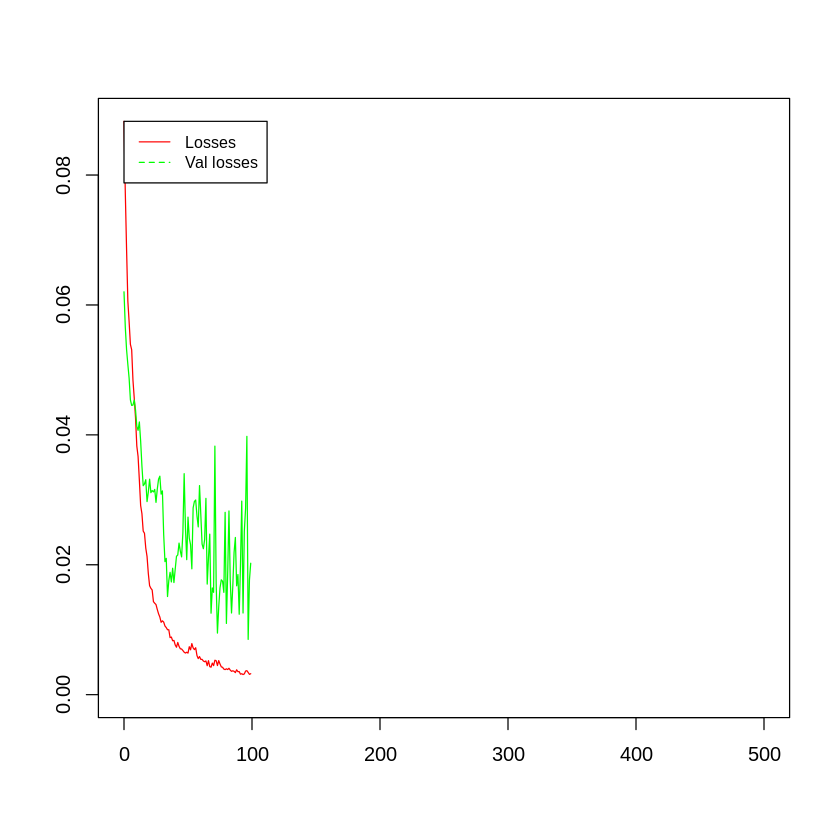

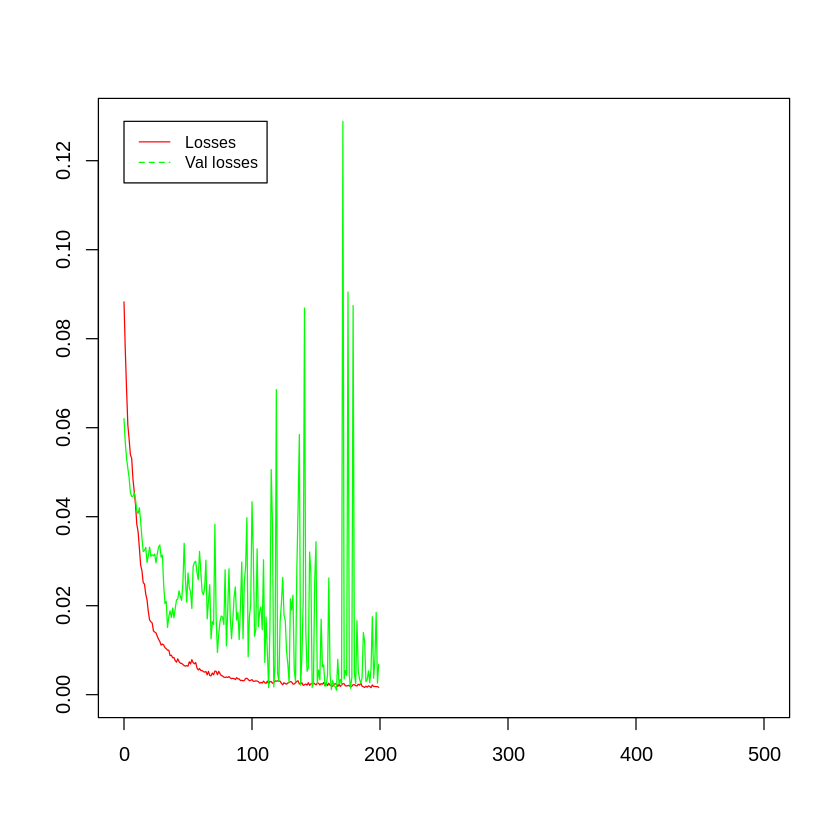

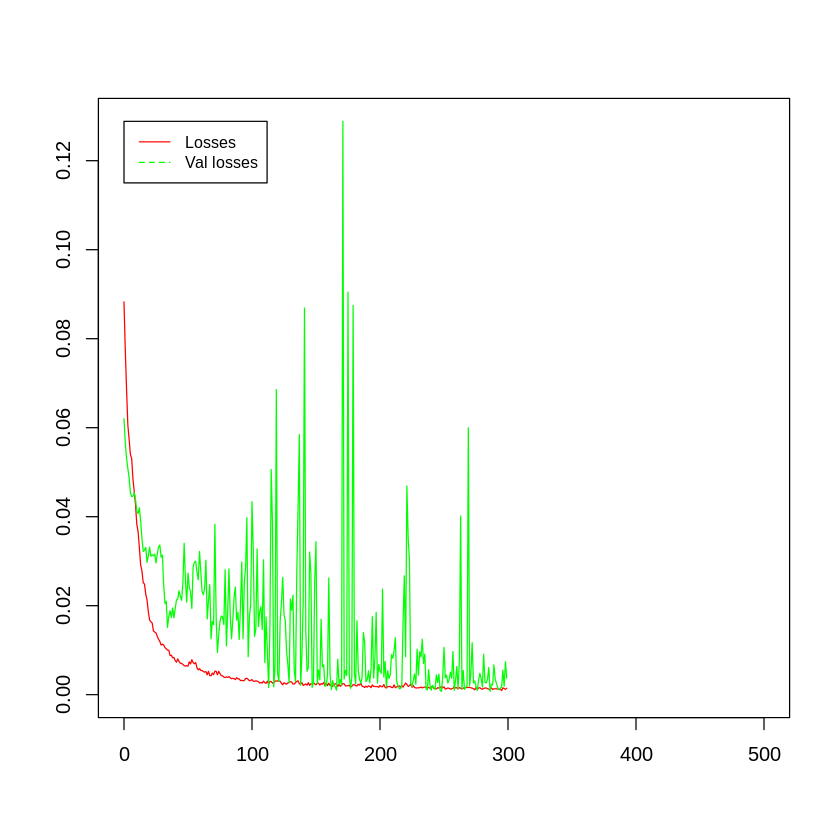

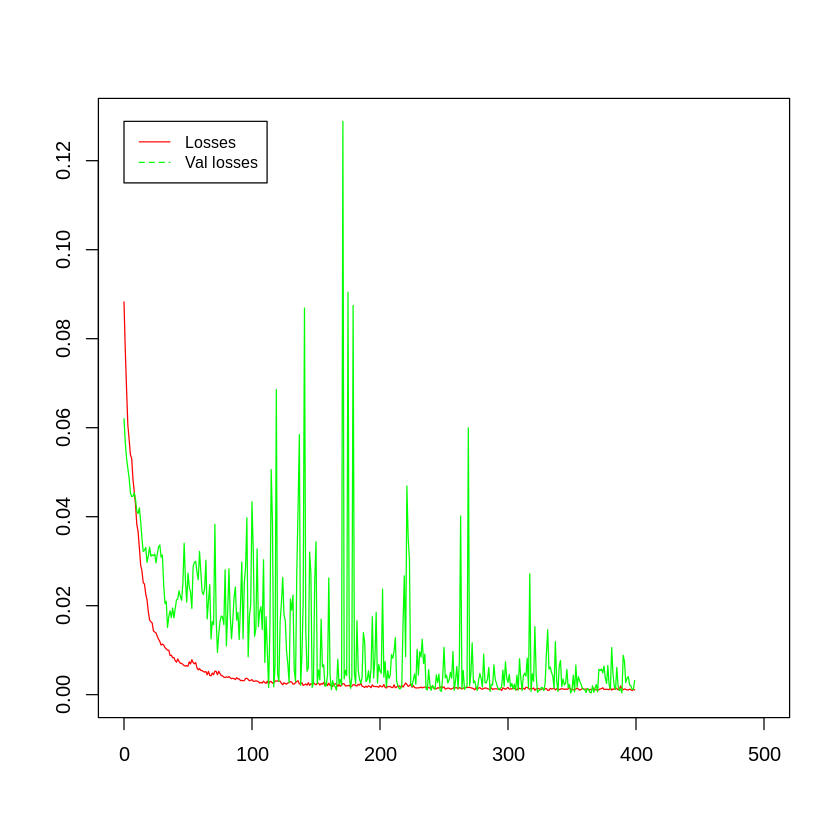

   user  system elapsed 
 81.886   2.018  75.893 

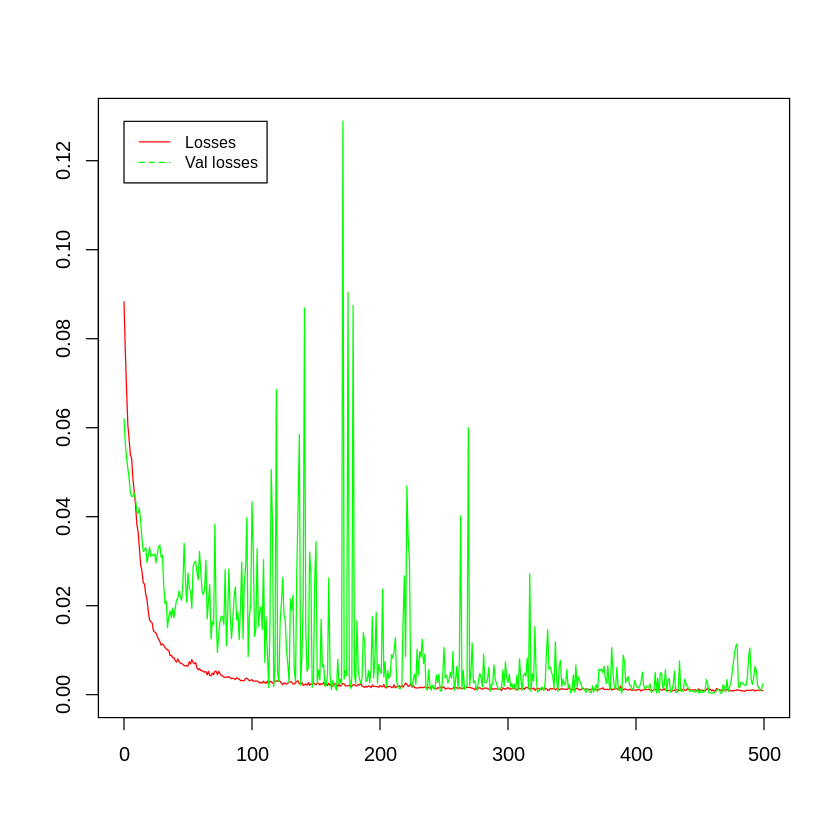

In [44]:
t1 <- proc.time()
    fit.Poland <- model.Poland %>% fit(x=x.train.Poland, y=y.train.Poland, epochs = epochs, 
                         batch_size =16, 
            verbose = 2, validation_split = 0.05, shuffle = T,callbacks=CBs_Poland)                             
proc.time()-t1

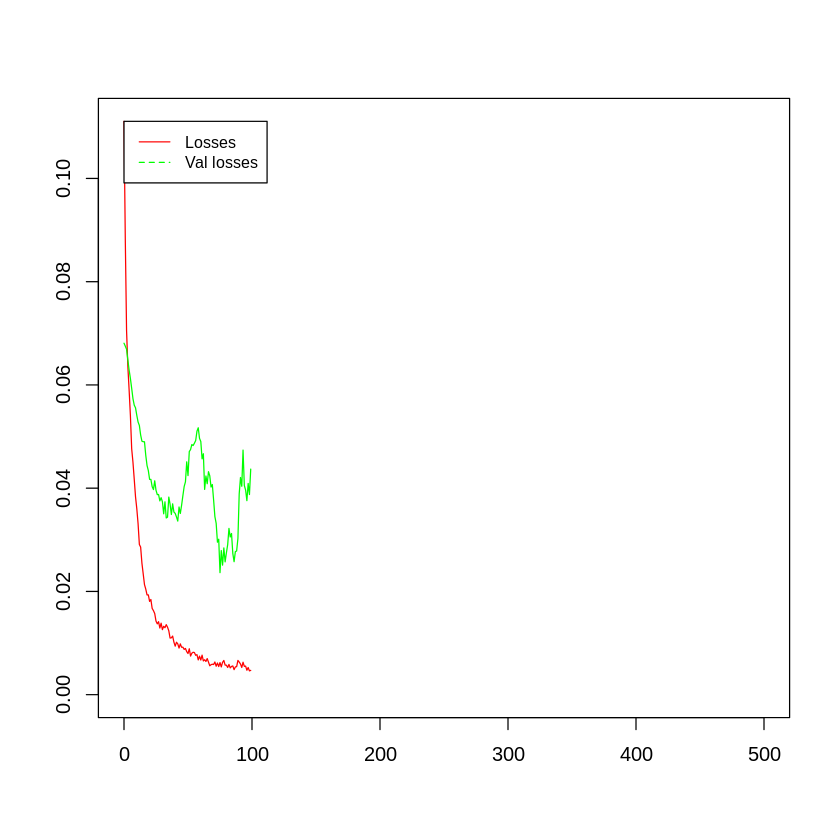

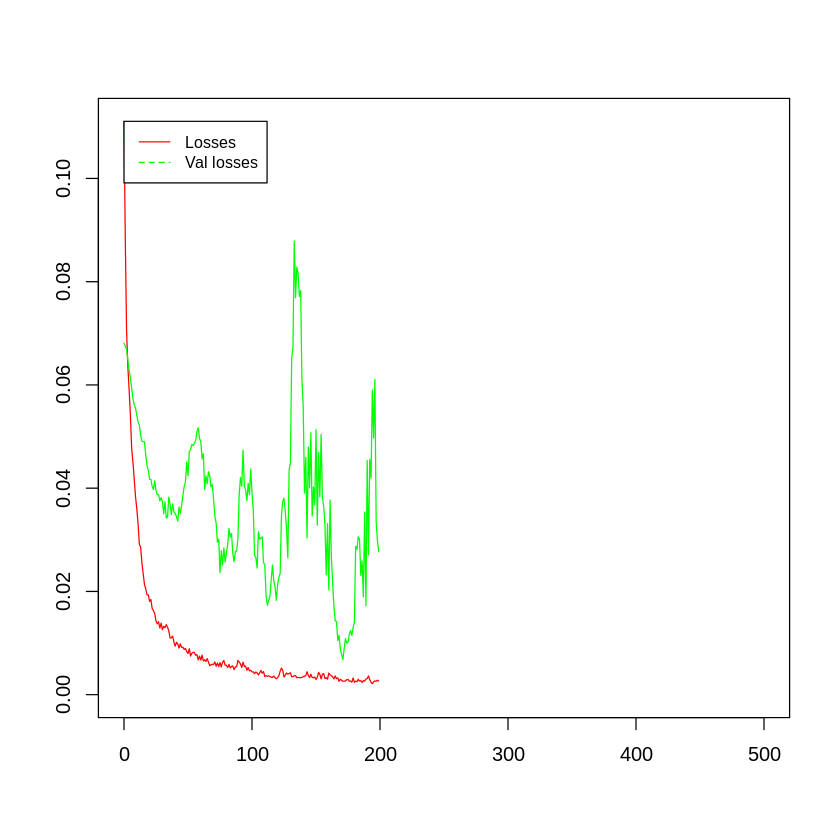

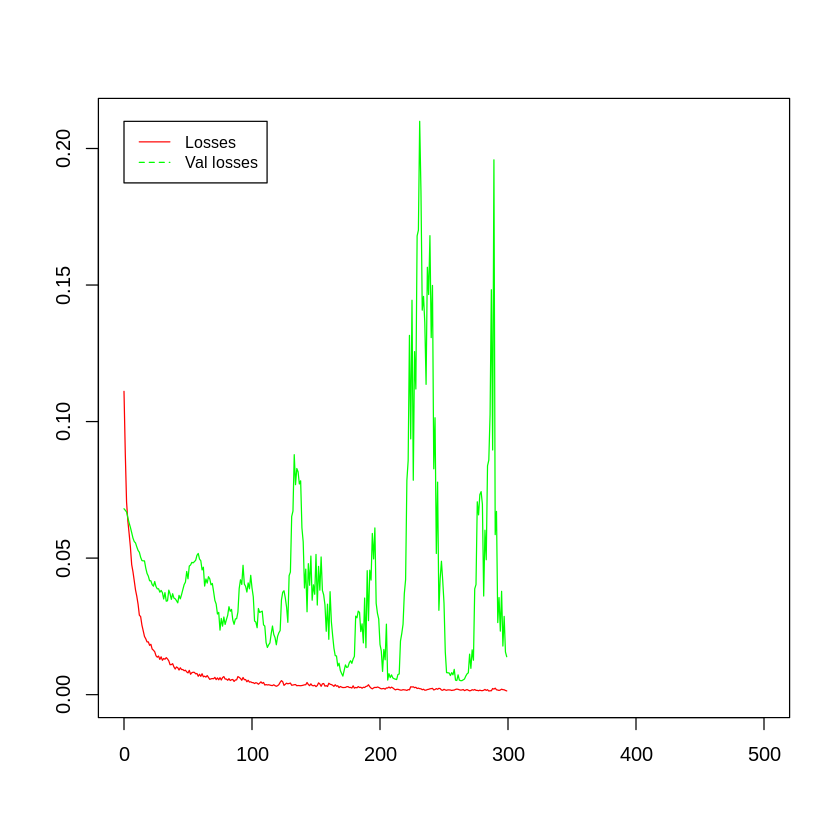

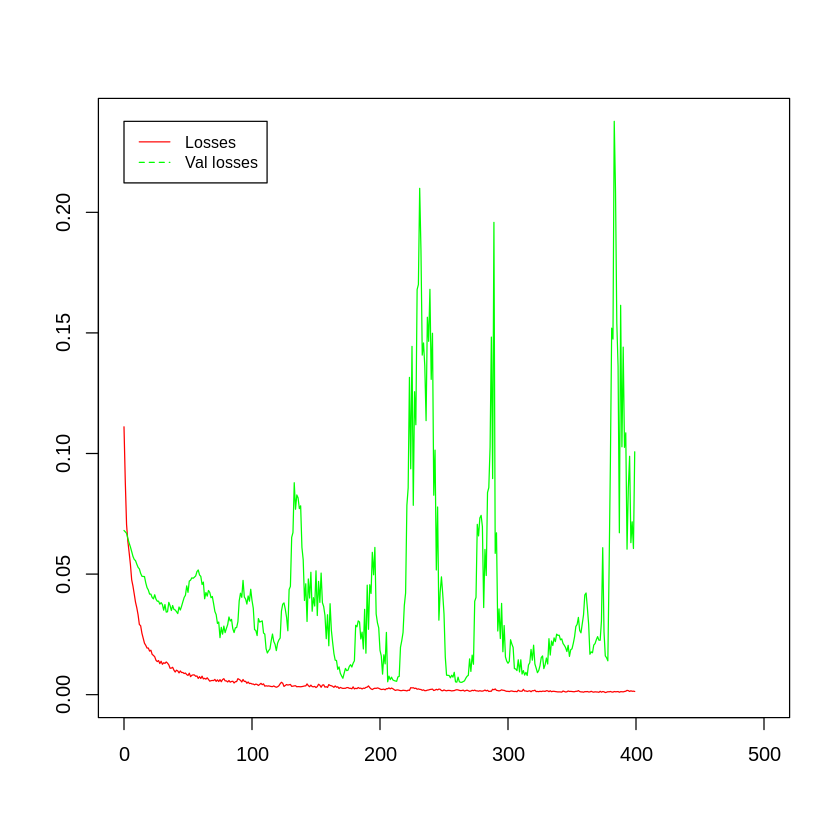

   user  system elapsed 
 67.413   1.223  63.774 

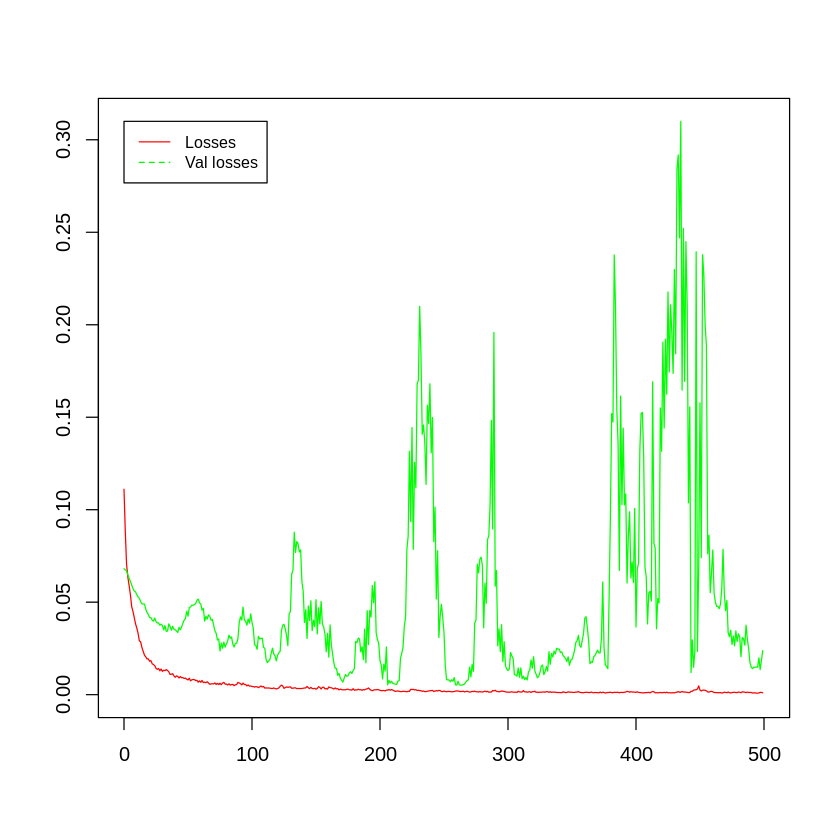

In [45]:
t1 <- proc.time()
    fit.Poland.Male <- model.Poland.Male %>% fit(x=x.train.Poland.Male, y=y.train.Poland.Male, epochs = epochs, 
                         batch_size =16, 
            verbose = 2, validation_split = 0.05, shuffle = T,callbacks=CBs_Poland_Male)                             
proc.time()-t1

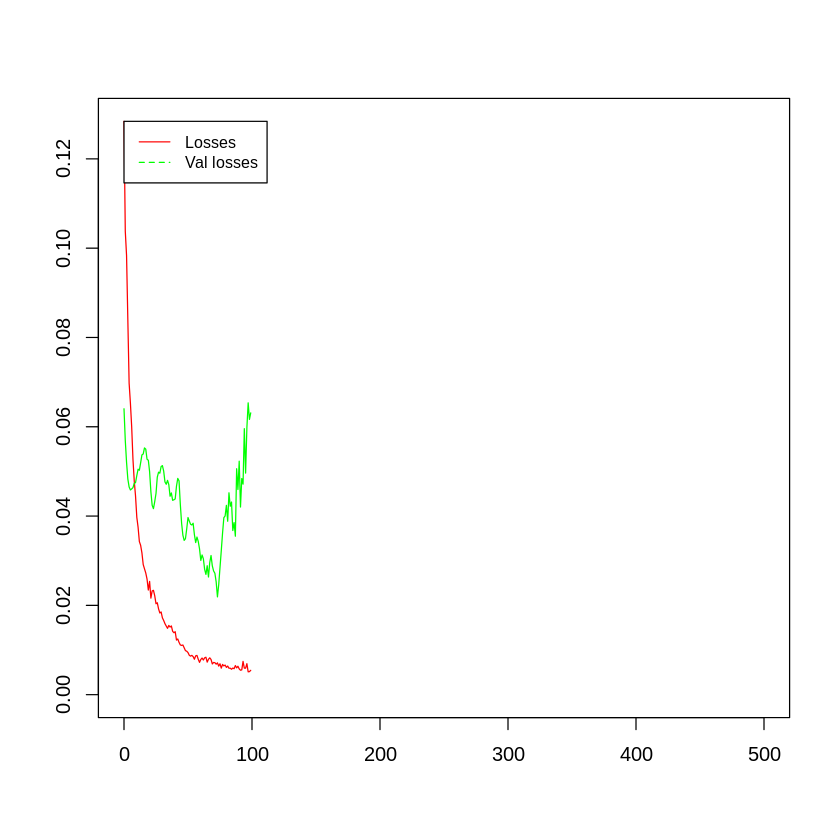

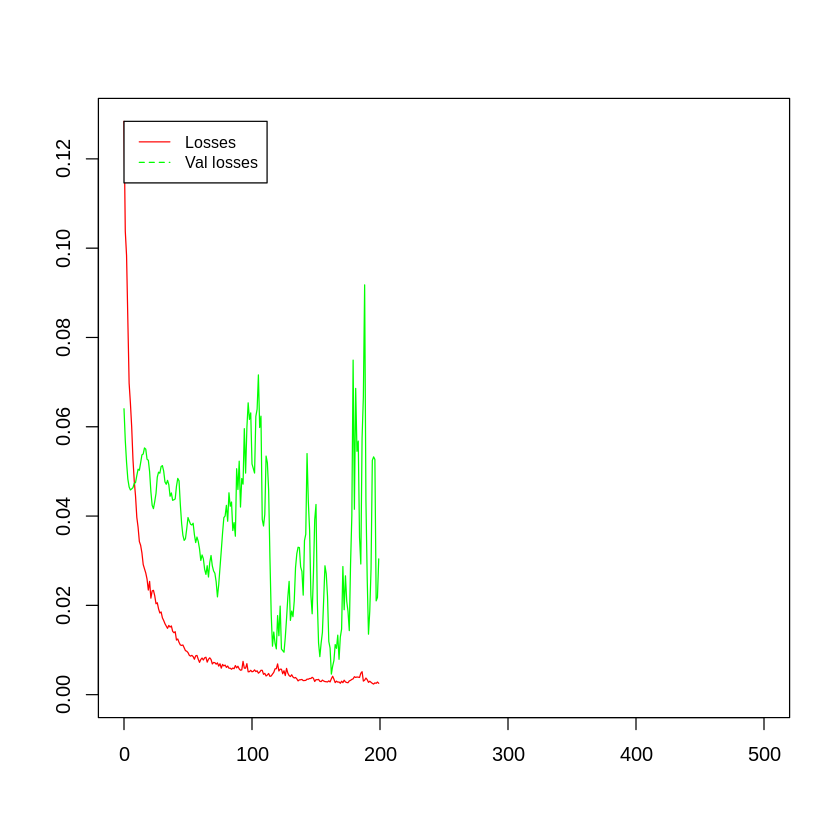

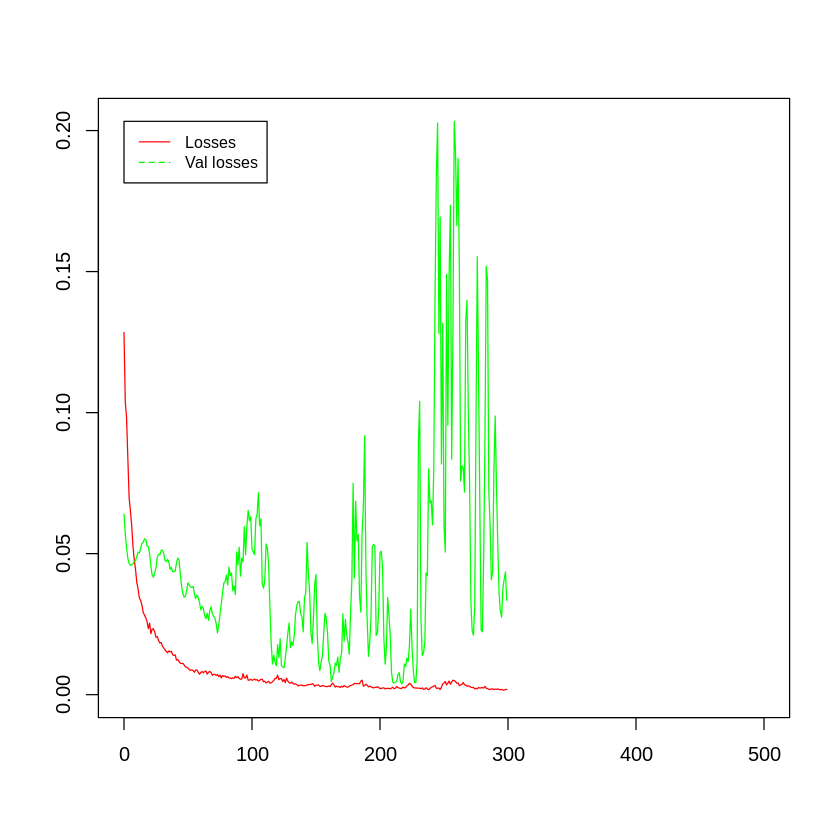

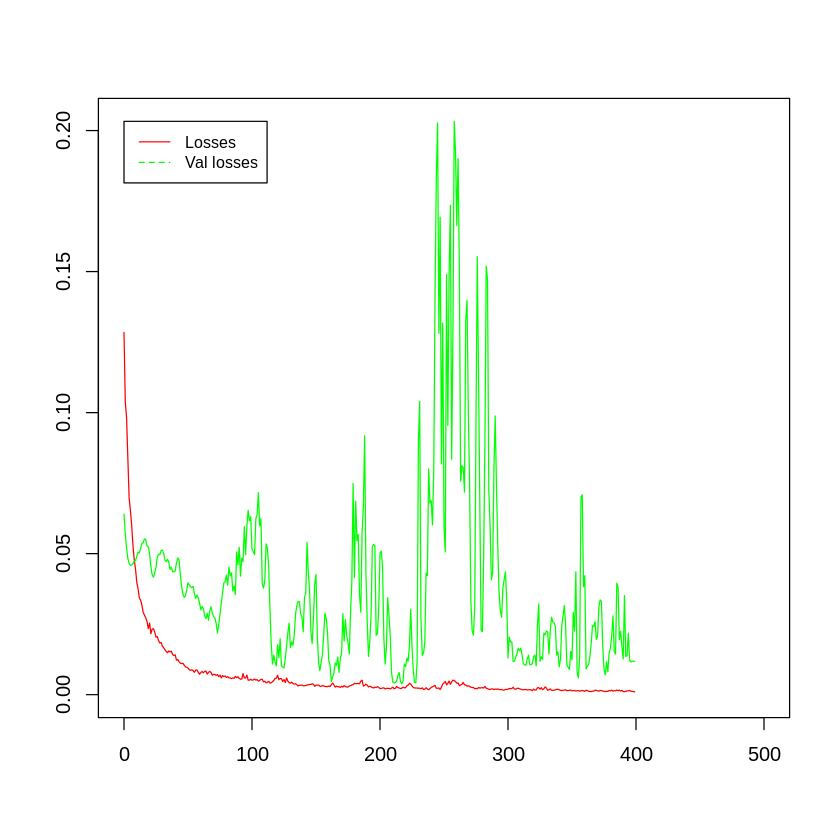

   user  system elapsed 
 67.265   1.373  64.527 

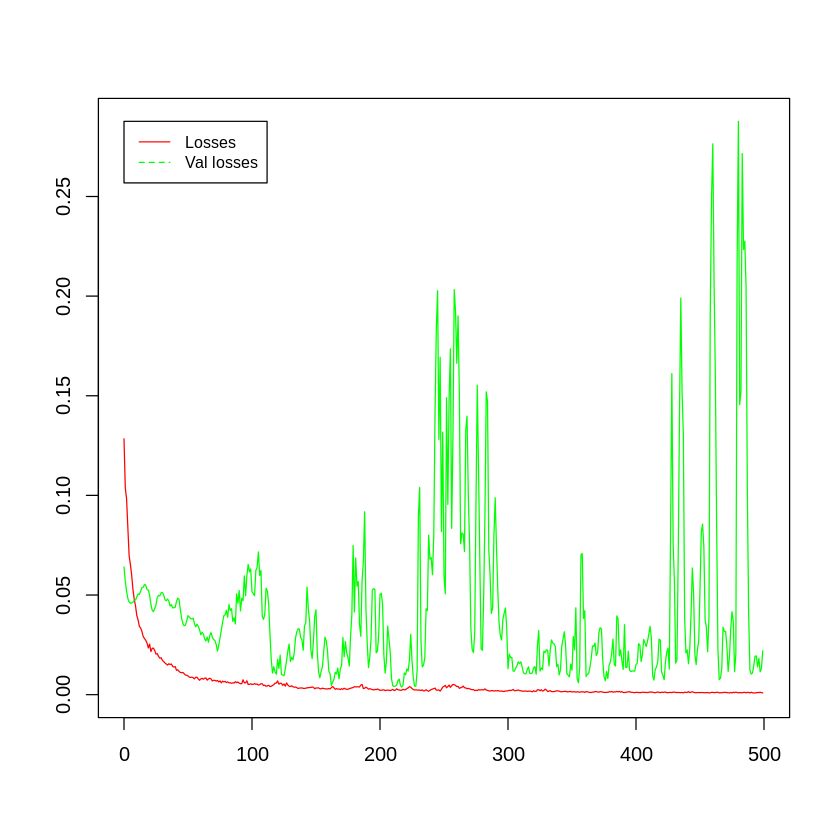

In [46]:
t1 <- proc.time()
    fit.Poland.Female <- model.Poland.Female %>% fit(x=x.train.Poland.Female, y=y.train.Poland.Female, epochs = epochs, 
                         batch_size =16, 
            verbose = 2, validation_split = 0.05, shuffle = T,callbacks=CBs_Poland_Female)                             
proc.time()-t1

### in-sample error (validation)

`geom_smooth()` using formula 'y ~ x'



[1] 0.0003084482

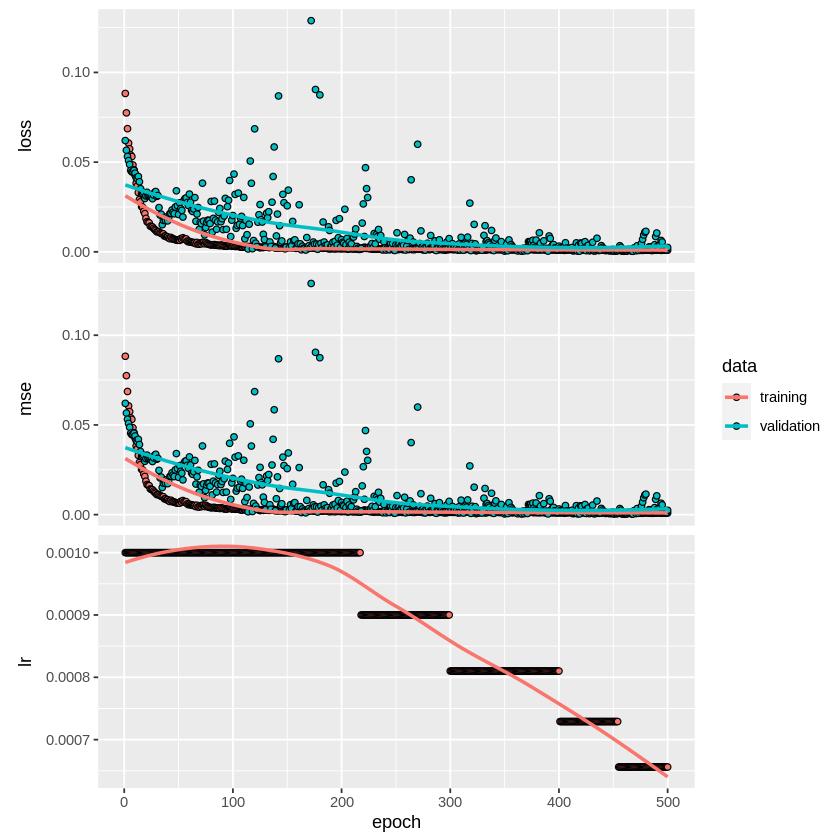

In [47]:
   
plot(fit.Poland)

fit.Poland$metrics$val_loss%>%min()



`geom_smooth()` using formula 'y ~ x'



[1] 0.005123119

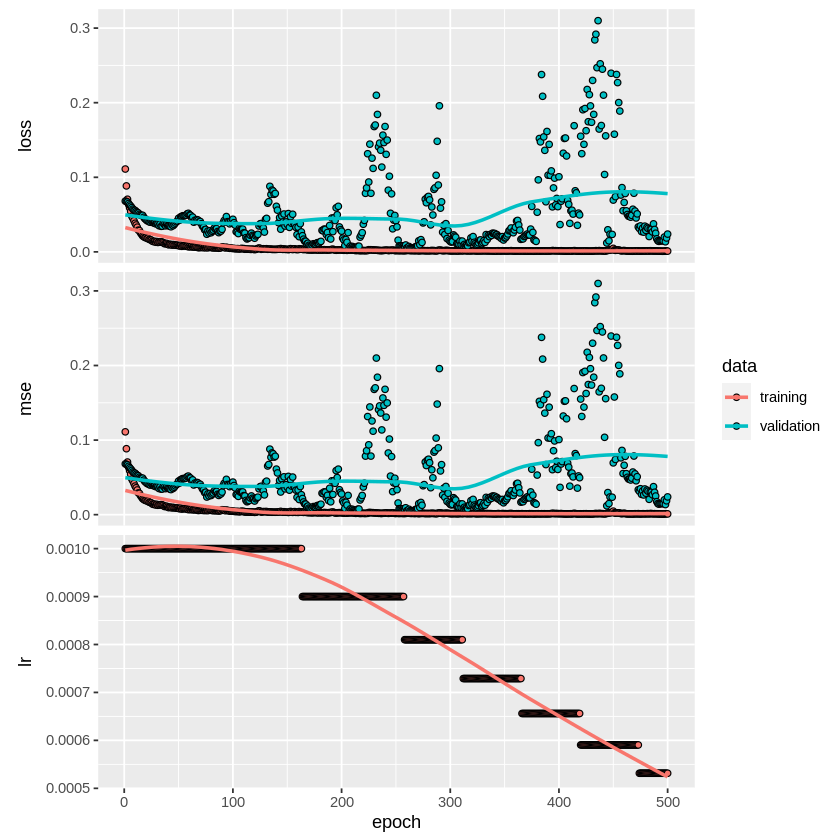

In [48]:
   
plot(fit.Poland.Male)

fit.Poland.Male$metrics$val_loss%>%min()



`geom_smooth()` using formula 'y ~ x'



[1] 0.003817573

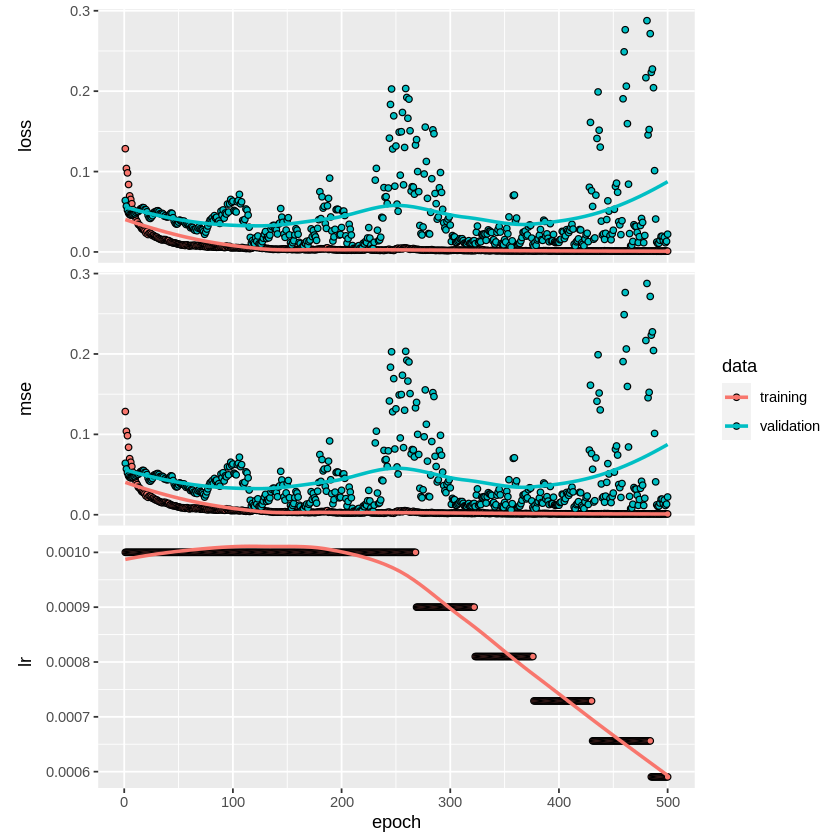

In [49]:
   
plot(fit.Poland.Female)

fit.Poland.Female$metrics$val_loss%>%min()



## Prediction
### Loading best model

In [50]:
#index = ".index"
#load_model_weights_hdf5(model.Poland, paste0(fileName,"_Poland", index))
#load_model_weights_hdf5(model.Poland.Male, paste0(fileName,"_Poland_Male", index))
#load_model_weights_hdf5(model.Poland.Female, paste0(fileName,"_Poland_Female", index))

### Setting up test data

In [51]:
testPoland <- Poland_full %>% filter(Year > (ObsYear-10))
testPoland.Male <- testPoland %>% filter(Gender == 'Male')
testPoland.Female <- testPoland %>% filter(Gender == "Female")

### Example prediction

In [52]:
pred.Poland.POL.F <- recursive.prediction.Poland(2000, testPoland, "Female", "POL",T0, val.min, val.max, model.Poland)
pred.Poland.POL.M <- recursive.prediction.Poland(2000, testPoland, "Male", "POL",T0, val.min, val.max, model.Poland)

In [53]:
pred.Poland.Gender.POL.F <- recursive.prediction.Poland(2000, testPoland, "Female", "POL",T0, val.min, val.max, model.Poland.Female)
pred.Poland.Gender.POL.M <- recursive.prediction.Poland(2000, testPoland, "Male", "POL",T0, val.min, val.max, model.Poland.Male)

Errors from example prediction

In [54]:
pred.Poland.POL.F[[2]]
pred.Poland.POL.M[[2]]

[1]  22.4770  27.0947  24.6882  31.8426  31.9828  36.7824  41.6727  45.5121
 [9]  55.5449  74.0556  85.9320  92.1061  95.4969 102.8905 117.5692 130.1763

[1]  29.4165  26.6820  27.0083  32.5317  34.7452  40.0950  48.6662  57.0708
 [9]  67.1448  81.9167  94.7989 102.3384 109.0864 133.1448 131.0167 145.7205

In [55]:
pred.Poland.Gender.POL.F[[2]]
pred.Poland.Gender.POL.M[[2]]

[1]  225.4024  282.8029  323.5937  353.9647  453.7408  730.2563  895.2968
 [8] 1092.1240 1460.5379 1546.7274 1998.6347 2444.8304 3277.7196 3645.6145
[15] 4269.8821 4432.0879

[1]  228.4678  244.9505  250.3225  303.9334  396.5473  456.0243  500.6015
 [8]  536.1013  722.5082  774.7354  806.6153  928.4639  900.2237 1024.4885
[15] 1169.5773 1250.3833

## Hyperparameters optimization
### Model with gender

In [56]:
fiter_size_vec = 2:32
pred.Poland.Pol.F.list = list()
pred.Poland.Pol.M.list = list()
for (m in 1:3) {
    for (q in fiter_size_vec) {
        cat(paste(m,q, "\n"))
        model.Poland <- CNN_both_genders(N, T0, 100, 'ADAM', q, m)
        fit.Poland <- model.Poland %>% fit(x=x.train.Poland, y=y.train.Poland, epochs = epochs, 
                         batch_size =16, verbose = 2, validation_split = 0.05, shuffle = T,callbacks=lr_callback)   
        plot(fit.Poland)

        fit.Poland$metrics$val_loss%>%min()
        #load_model_weights_hdf5(model.Poland, paste0(fileName,"_Poland", index))
        pred.Poland.POL.F <- recursive.prediction.Poland(2000, testPoland, "Female", "POL",T0, val.min, val.max, model.Poland)
        pred.Poland.POL.M <- recursive.prediction.Poland(2000, testPoland, "Male", "POL",T0, val.min, val.max, model.Poland)
                
        pred.Poland.Pol.F.list[[m*100+q]] = pred.Poland.POL.F[[2]]
        pred.Poland.Pol.M.list[[m*100+q]] = pred.Poland.POL.M[[2]]
    }
}
#model.Poland <- CNN_both_genders(N, T0, 100)


1 2 
1 3 
1 4 
1 5 
1 6 
1 7 
1 8 
1 9 
1 10 
1 11 
1 12 
1 13 
1 14 
1 15 
1 16 
1 17 
1 18 
1 19 
1 20 
1 21 
1 22 
1 23 
1 24 
1 25 
1 26 
1 27 
1 28 
1 29 
1 30 
1 31 
1 32 
2 2 
2 3 
2 4 
2 5 
2 6 
2 7 
2 8 
2 9 
2 10 
2 11 
2 12 
2 13 
2 14 
2 15 
2 16 
2 17 
2 18 
2 19 
2 20 
2 21 
2 22 
2 23 
2 24 
2 25 
2 26 
2 27 
2 28 
2 29 
2 30 
2 31 
2 32 
3 2 
3 3 
3 4 
3 5 
3 6 
3 7 
3 8 
3 9 
3 10 
3 11 
3 12 
3 13 
3 14 
3 15 
3 16 
3 17 
3 18 
3 19 
3 20 
3 21 
3 22 
3 23 
3 24 
3 25 
3 26 
3 27 
3 28 
3 29 
3 30 
3 31 
3 32 


In [60]:
pred.Poland.Pol.M.list

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

[[11]]
NULL

[[12]]
NULL

[[13]]
NULL

[[14]]
NULL

[[15]]
NULL

[[16]]
NULL

[[17]]
NULL

[[18]]
NULL

[[19]]
NULL

[[20]]
NULL

[[21]]
NULL

[[22]]
NULL

[[23]]
NULL

[[24]]
NULL

[[25]]
NULL

[[26]]
NULL

[[27]]
NULL

[[28]]
NULL

[[29]]
NULL

[[30]]
NULL

[[31]]
NULL

[[32]]
NULL

[[33]]
NULL

[[34]]
NULL

[[35]]
NULL

[[36]]
NULL

[[37]]
NULL

[[38]]
NULL

[[39]]
NULL

[[40]]
NULL

[[41]]
NULL

[[42]]
NULL

[[43]]
NULL

[[44]]
NULL

[[45]]
NULL

[[46]]
NULL

[[47]]
NULL

[[48]]
NULL

[[49]]
NULL

[[50]]
NULL

[[51]]
NULL

[[52]]
NULL

[[53]]
NULL

[[54]]
NULL

[[55]]
NULL

[[56]]
NULL

[[57]]
NULL

[[58]]
NULL

[[59]]
NULL

[[60]]
NULL

[[61]]
NULL

[[62]]
NULL

[[63]]
NULL

[[64]]
NULL

[[65]]
NULL

[[66]]
NULL

[[67]]
NULL

[[68]]
NULL

[[69]]
NULL

[[70]]
NULL

[[71]]
NULL

[[72]]
NULL

[[73]]
NULL

[[74]]
NULL

[[75]]
NULL

[[76]]
NULL

[[77]]
NULL

[[78]]
NULL

[[79]]
NULL

[[80]]
NULL

[[81]]
NULL

[[82]]
NULL

[[83]]
NULL

[[84]]
NULL

[[85]]
NULL

[[86]]
NULL

[[87]]
NULL

[[88]]
NULL

[[89]]
NULL

[[90]]
NULL

[[91]]
NULL

[[92]]
NULL

[[93]]
NULL

[[94]]
NULL

[[95]]
NULL

[[96]]
NULL

[[97]]
NULL

[[98]]
NULL

[[99]]
NULL

[[100]]
NULL

[[101]]
NULL

[[102]]
 [1] 36.0604 24.4052 22.6237 21.4973 18.5126 15.1568 16.0989 16.8460 18.4472
[10] 22.7369 22.3271 25.6557 32.8058 42.2700 41.6427 43.0935

[[103]]
 [1]  21.8543  22.9746  25.9726  27.1027  41.0531  49.0577  76.9052  82.9498
 [9] 124.2430 131.5683 191.6756 202.2656 245.6041 257.7515 305.1945 332.3511

[[104]]
 [1]  284.9233  287.8145  576.1991  610.0349 1192.6370 1224.4506 2023.1462
 [8] 2067.2863 2737.6638 2785.9553 3273.5894 3280.6542 3558.4212 3585.4859
[15] 3748.2487 3710.7064

[[105]]
 [1]  82.9247  84.3477  96.4981 102.7585 110.2090 122.8435 139.4041 162.9812
 [9] 204.4186 252.7778 309.7858 380.2195 451.5288 558.2848 674.7812 814.0526

[[106]]
 [1]  34.1595  45.6053  49.2153  63.9352  75.8250  98.5176 116.4760 142.9876
 [9] 165.6182 198.0819 229.3694 248.0036 275.3644 301.5734 321.3924 347.9376

[[107]]
 [1]  39.8270  54.9629  55.5561  77.9599  80.9028 113.1563 123.5877 165.2195
 [9] 191.8023 250.9802 310.3898 361.4092 439.3465 521.6538 599.2486 687.3936

[[108]]
 [1]  285.2263  125.4583  341.6464  159.6559  313.0959  369.8493  616.8937
 [8]  791.2912 1210.7170 1446.5553 1891.8150 2227.3069 2077.8248 2540.5675
[15] 2594.7128 2663.0421

[[109]]
 [1]   27.2763   34.7318   34.4964   50.5611   47.0435   66.2256   71.9940
 [8]  111.0375  124.0929  221.5447  308.5574  440.0313  706.6004  994.8351
[15] 1387.1890 1758.6609

[[110]]
 [1]  57.8140  52.0168  44.7272  37.8245  38.9516  34.9625  45.2554  48.6159
 [9]  67.6498  81.7479 107.3665 126.3707 144.7300 179.4520 197.4350 229.0072

[[111]]
 [1]  34.5179  20.1196  21.1037  13.4369  33.4808  24.3049  46.7192  36.0798
 [9]  66.2544  55.4777  81.9002  75.6343  89.0966 108.7883 105.9779 125.4995

[[112]]
 [1]  523.7905  787.6064 1239.9804 1539.4344 2085.6054 2387.8927 2873.2693
 [8] 3142.2119 3480.0634 3668.0078 3814.7475 3920.3497 4041.5478 4175.8701
[15] 4181.4826 4187.1994

[[113]]
 [1] 70.8284 18.5157  9.3493 16.2813 33.8641 31.3185 46.1665 40.4793 53.7510
[10] 28.0995 50.6945 19.2395 22.3361 18.8679 25.3954 21.4717

[[114]]
 [1] 12.5902 11.7460 18.6433 18.7831 27.1980 24.0319 31.3276 30.0806 35.0971
[10] 39.5845 43.8678 44.4580 48.6633 60.1093 59.9530 66.7854

[[115]]
 [1]  27.6605  35.4045  32.6166  47.0610  55.4638  80.8394  99.6312 140.0070
 [9] 186.9738 229.7494 304.1444 346.6195 395.5089 425.0202 486.7159 524.8975

[[116]]
 [1]  84.6244 135.5393 163.4212 218.1718 262.9608 309.3701 354.6117 397.2379
 [9] 428.7490 458.0332 499.4861 508.9490 513.3172 512.2823 521.0835 525.5868

[[117]]
 [1]  36.0796  21.4111  47.8180  33.0287  51.0518  45.9626  65.4423  86.9298
 [9] 122.2157 163.3171 271.4259 332.0166 411.2546 383.1320 524.9460 433.8536

[[118]]
 [1]  17.8081  22.7597  18.7951  25.9374  

### Models per geder

In [58]:
fiter_size_vec = 2:32
pred.Poland.Male.M.list = list()
for (m in 1:3) {
    for (q in fiter_size_vec) {
        cat(paste(m,q, "\n"))
        model.Poland.Male <- CNN_single_gender(N, T0, 100, 'ADAM', q, m)
        fit.Poland.Male <- model.Poland.Male %>% fit(x=x.train.Poland.Male, y=y.train.Poland.Male, epochs = epochs, 
                         batch_size =16, verbose = 2, validation_split = 0.05, shuffle = T,callbacks=lr_callback)   
        plot(fit.Poland.Male)

        fit.Poland$metrics$val_loss%>%min()
        pred.Poland.Male.M <- recursive.prediction.Poland(2000, testPoland.Male, "Male", "POL",T0, val.min, val.max, model.Poland.Male)
                
        pred.Poland.Male.M.list[[m*100+q]] = pred.Poland.Male.M[[2]]
    }
}
#model.Poland <- CNN_both_genders(N, T0, 100)


1 2 
1 3 
1 4 
1 5 
1 6 
1 7 
1 8 
1 9 
1 10 
1 11 
1 12 
1 13 
1 14 
1 15 
1 16 
1 17 
1 18 
1 19 
1 20 
1 21 
1 22 
1 23 
1 24 
1 25 
1 26 
1 27 
1 28 
1 29 
1 30 
1 31 
1 32 
2 2 
2 3 
2 4 
2 5 
2 6 
2 7 
2 8 
2 9 
2 10 
2 11 
2 12 
2 13 
2 14 
2 15 
2 16 
2 17 
2 18 
2 19 
2 20 
2 21 
2 22 
2 23 
2 24 
2 25 
2 26 
2 27 
2 28 
2 29 
2 30 
2 31 
2 32 
3 2 
3 3 
3 4 
3 5 
3 6 
3 7 
3 8 
3 9 
3 10 
3 11 
3 12 
3 13 
3 14 
3 15 
3 16 
3 17 
3 18 
3 19 
3 20 
3 21 
3 22 
3 23 
3 24 
3 25 
3 26 
3 27 
3 28 
3 29 
3 30 
3 31 
3 32 


In [57]:
fiter_size_vec = 2:32
pred.Poland.Female.F.list = list()
for (m in 1:3) {
    for (q in fiter_size_vec) {
        cat(paste(m,q, "\n"))
        model.Poland.Female <- CNN_single_gender(N, T0, 100, 'ADAM', q, m)
        fit.Poland.Female <- model.Poland.Female %>% fit(x=x.train.Poland.Female, y=y.train.Poland.Female, epochs = epochs, 
                         batch_size =16, verbose = 2, validation_split = 0.05, shuffle = T,callbacks=lr_callback)   
        plot(fit.Poland.Female)

        fit.Poland.Female$metrics$val_loss%>%min()
        pred.Poland.Female.F <- recursive.prediction.Poland(2000, testPoland.Female, "Female", "POL",T0, val.min, val.max, model.Poland.Female)
                
        pred.Poland.Female.F.list[[m*100+q]] = pred.Poland.Female.F[[2]]
    }
}
#model.Poland <- CNN_both_genders(N, T0, 100)


1 2 
1 3 
1 4 
1 5 
1 6 
1 7 
1 8 
1 9 
1 10 
1 11 
1 12 
1 13 
1 14 
1 15 
1 16 
1 17 
1 18 
1 19 
1 20 
1 21 
1 22 
1 23 
1 24 
1 25 
1 26 
1 27 
1 28 
1 29 
1 30 
1 31 
1 32 
2 2 
2 3 
2 4 
2 5 
2 6 
2 7 
2 8 
2 9 
2 10 
2 11 
2 12 
2 13 
2 14 
2 15 
2 16 
2 17 
2 18 
2 19 
2 20 
2 21 
2 22 
2 23 
2 24 
2 25 
2 26 
2 27 
2 28 
2 29 
2 30 
2 31 
2 32 
3 2 
3 3 
3 4 
3 5 
3 6 
3 7 
3 8 
3 9 
3 10 
3 11 
3 12 
3 13 
3 14 
3 15 
3 16 
3 17 
3 18 
3 19 
3 20 
3 21 
3 22 
3 23 
3 24 
3 25 
3 26 
3 27 
3 28 
3 29 
3 30 
3 31 
3 32 


In [61]:
pred.Poland.Male.M.list

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

[[11]]
NULL

[[12]]
NULL

[[13]]
NULL

[[14]]
NULL

[[15]]
NULL

[[16]]
NULL

[[17]]
NULL

[[18]]
NULL

[[19]]
NULL

[[20]]
NULL

[[21]]
NULL

[[22]]
NULL

[[23]]
NULL

[[24]]
NULL

[[25]]
NULL

[[26]]
NULL

[[27]]
NULL

[[28]]
NULL

[[29]]
NULL

[[30]]
NULL

[[31]]
NULL

[[32]]
NULL

[[33]]
NULL

[[34]]
NULL

[[35]]
NULL

[[36]]
NULL

[[37]]
NULL

[[38]]
NULL

[[39]]
NULL

[[40]]
NULL

[[41]]
NULL

[[42]]
NULL

[[43]]
NULL

[[44]]
NULL

[[45]]
NULL

[[46]]
NULL

[[47]]
NULL

[[48]]
NULL

[[49]]
NULL

[[50]]
NULL

[[51]]
NULL

[[52]]
NULL

[[53]]
NULL

[[54]]
NULL

[[55]]
NULL

[[56]]
NULL

[[57]]
NULL

[[58]]
NULL

[[59]]
NULL

[[60]]
NULL

[[61]]
NULL

[[62]]
NULL

[[63]]
NULL

[[64]]
NULL

[[65]]
NULL

[[66]]
NULL

[[67]]
NULL

[[68]]
NULL

[[69]]
NULL

[[70]]
NULL

[[71]]
NULL

[[72]]
NULL

[[73]]
NULL

[[74]]
NULL

[[75]]
NULL

[[76]]
NULL

[[77]]
NULL

[[78]]
NULL

[[79]]
NULL

[[80]]
NULL

[[81]]
NULL

[[82]]
NULL

[[83]]
NULL

[[84]]
NULL

[[85]]
NULL

[[86]]
NULL

[[87]]
NULL

[[88]]
NULL

[[89]]
NULL

[[90]]
NULL

[[91]]
NULL

[[92]]
NULL

[[93]]
NULL

[[94]]
NULL

[[95]]
NULL

[[96]]
NULL

[[97]]
NULL

[[98]]
NULL

[[99]]
NULL

[[100]]
NULL

[[101]]
NULL

[[102]]
 [1] 1175.5408 1197.0081  464.0881 1207.8470  618.9537  821.4625  276.1072
 [8] 1083.1612  538.8163  676.5350  376.5412  596.4471 1002.7416  489.8340
[15] 1135.9229  996.1436

[[103]]
 [1] 239.3942 250.5549 222.2355 230.1190 206.7603 216.5252 187.8017 192.1487
 [9] 152.2319 153.1173 119.2971 116.1739 117.3795 121.6428 119.2866 127.4510

[[104]]
 [1]  639.2977   97.6410  106.9320   96.3196   93.4249   57.0470  114.2809
 [8]  200.7859  215.0604   93.2399  144.4660 1852.7173  300.6954  264.7327
[15]  328.6375  326.5306

[[105]]
 [1]  613.5086  517.6288  111.2972  196.5754  120.8518  135.5847  129.9559
 [8]  769.8649  308.9856 1205.3745  431.2687  824.4250  940.0648  383.1038
[15]  319.4376  227.5803

[[106]]
 [1]  62.8030  15.9365  23.0406  21.6797  27.8996  34.4794  62.2520  67.1281
 [9]  93.8069 124.7053 142.5467 115.3465 145.2778 155.5387 155.7963 179.2994

[[107]]
 [1] 1235.9145  504.0411  669.9917  217.4264  259.4692  199.2337  201.3404
 [8]  199.3606  347.1124  655.6806  779.3875 2187.3891 1326.0270 1882.6006
[15]  653.0160  488.4327

[[108]]
 [1] 1493.9614  287.2149  352.2330  162.6737  152.3830  171.6907  128.4312
 [8]  493.9805  356.3433  670.6337  898.9977 2723.7757 2101.3506 2611.0207
[15] 2437.9011 1614.1333

[[109]]
 [1] 1159.842 2826.718 3718.304 4137.653 4267.090 4372.061 4446.036 4533.483
 [9] 4596.847 4662.032 4653.198 4678.842 4671.780 4695.538 4678.710 4663.321

[[110]]
 [1] 249.3809  97.5797  52.6464  41.5293 109.0759  43.3298  60.1045  49.8638
 [9] 390.9512  73.5763 286.9654 128.3769 177.6905 255.2579 204.1415 322.0774

[[111]]
 [1]  45.1089  46.8901  52.3082  80.3117  80.6598 104.2056 242.0909 413.0154
 [9] 838.8148 376.7598 736.1050 511.3570 933.1248 536.4622 400.7995 450.3028

[[112]]
 [1] 2283.0828  464.1347  338.0411  729.6846  292.8304  650.2256  375.2740
 [8] 3367.7385  878.5347 2327.2810 1043.8356 1192.7237 1399.1175  860.4807
[15] 1748.5342  957.2893

[[113]]
 [1]  300.5056  167.9710  393.4064  518.8401  570.9834  605.2449  839.8631
 [8] 1581.6797 1973.5319 2107.2645 2007.0455 2146.2204 1625.0184 1435.9072
[15]  684.4588  831.8108

[[114]]
 [1] 258.9410 320.4228 364.3104 393.3560 432.3654 425.3797 440.4277 416.3884
 [9] 417.8939 398.3518 438.0771 502.9331 521.6622 545.5678 544.8027 561.8769

[[115]]
 [1] 307.4693 296.8796 297.7032 260.8939 271.4768 239.4548 215.4486 207.0156
 [9] 232.1709 324.5625 373.6722 411.7012 450.5182 487.3413 488.4645 487.8858

[[116]]
 [1]  213.8131   98.1462  116.6078  153.3280  193.9840  333.0646  350.5651
 [8]  328.9424  368.2031  350.2271  440.0959  480.1476  655.3860 2100.0508
[15] 1445.6036 2570.4096

[[117]]
 [1]  851.9325  999.3295 2162.8591 2546.7849 3823.2103 3993.3147 4262.728